<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2025-10-17 10:29:15--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2025-10-17 10:29:17--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2025-10-17 10:29:17 (49.1 MB/s) - ‘utils.py’ saved [2627/2627]



In [1]:
%run 'utils.py'

In [2]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"


In [7]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=0),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            nn.ReLU(),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.405s (0.405s)	Loss 2.3021 (2.3021)	Prec@1   9.4 (  9.4)	Prec@5  57.0 ( 57.0)


<Figure size 640x480 with 0 Axes>

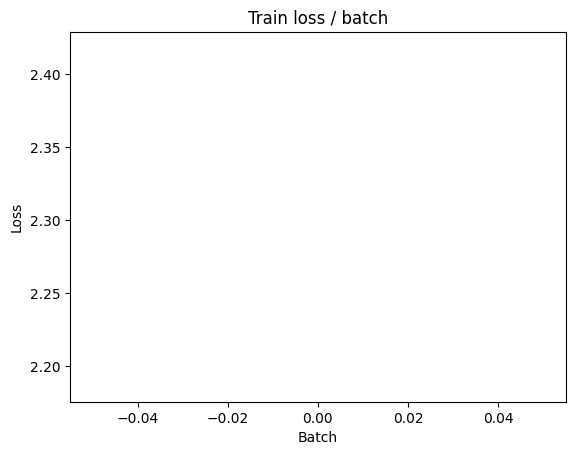

[TRAIN Batch 200/391]	Time 0.125s (0.144s)	Loss 2.2804 (2.2850)	Prec@1  14.1 ( 14.7)	Prec@5  54.7 ( 54.0)


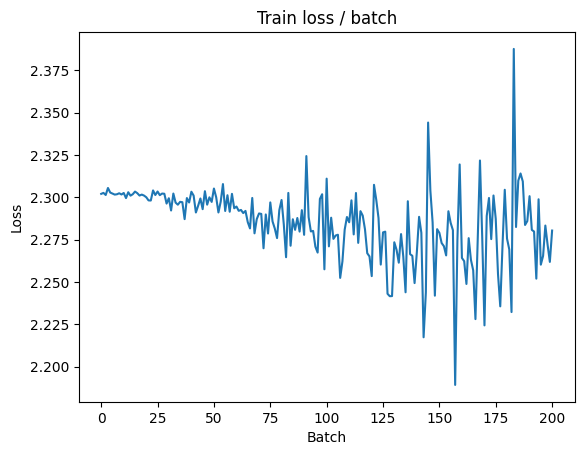


===============> Total time 53s	Avg loss 2.2764	Avg Prec@1 15.83 %	Avg Prec@5 55.41 %

[EVAL Batch 000/079]	Time 0.163s (0.163s)	Loss 2.3406 (2.3406)	Prec@1   8.6 (  8.6)	Prec@5  50.0 ( 50.0)

===============> Total time 3s	Avg loss 2.3052	Avg Prec@1 12.55 %	Avg Prec@5 51.34 %



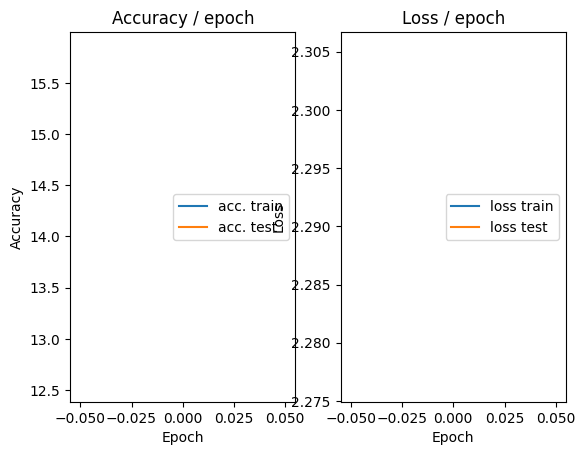

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.274s (0.274s)	Loss 2.2767 (2.2767)	Prec@1  14.8 ( 14.8)	Prec@5  52.3 ( 52.3)


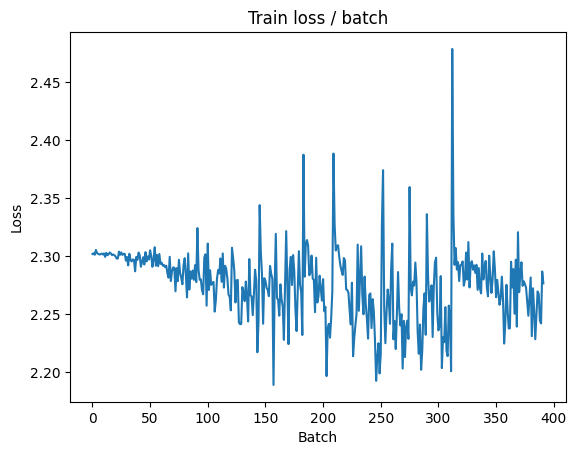

[TRAIN Batch 200/391]	Time 0.109s (0.146s)	Loss 2.1387 (2.1773)	Prec@1  27.3 ( 23.7)	Prec@5  62.5 ( 61.0)


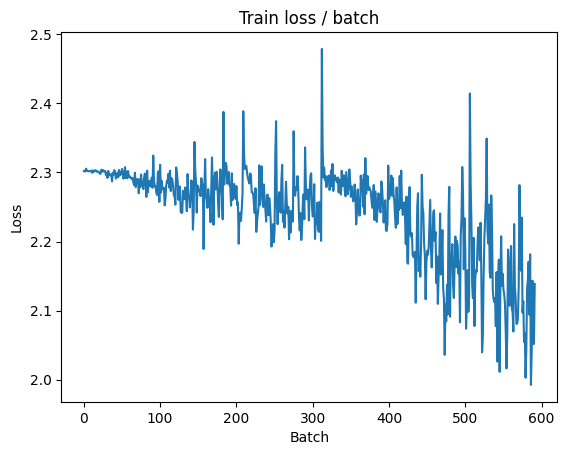


===============> Total time 55s	Avg loss 2.0768	Avg Prec@1 27.37 %	Avg Prec@5 67.85 %

[EVAL Batch 000/079]	Time 0.265s (0.265s)	Loss 2.1550 (2.1550)	Prec@1  26.6 ( 26.6)	Prec@5  68.0 ( 68.0)

===============> Total time 5s	Avg loss 2.0439	Avg Prec@1 28.85 %	Avg Prec@5 73.13 %



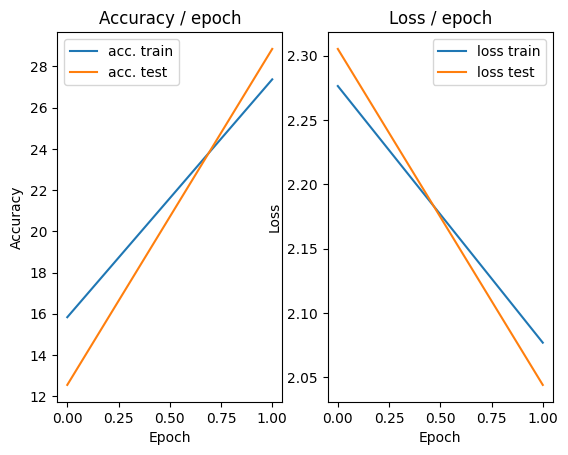

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.393s (0.393s)	Loss 2.1108 (2.1108)	Prec@1  25.0 ( 25.0)	Prec@5  72.7 ( 72.7)


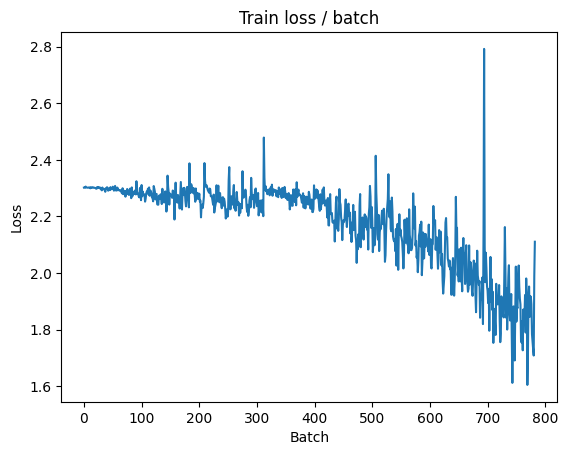

[TRAIN Batch 200/391]	Time 0.111s (0.139s)	Loss 1.4148 (1.7240)	Prec@1  50.8 ( 39.2)	Prec@5  94.5 ( 84.6)


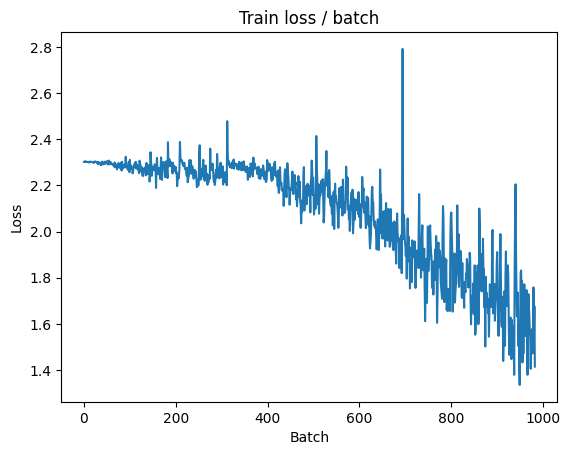


===============> Total time 54s	Avg loss 1.6278	Avg Prec@1 42.12 %	Avg Prec@5 87.61 %

[EVAL Batch 000/079]	Time 0.298s (0.298s)	Loss 1.3965 (1.3965)	Prec@1  54.7 ( 54.7)	Prec@5  95.3 ( 95.3)

===============> Total time 4s	Avg loss 1.5300	Avg Prec@1 45.45 %	Avg Prec@5 91.89 %



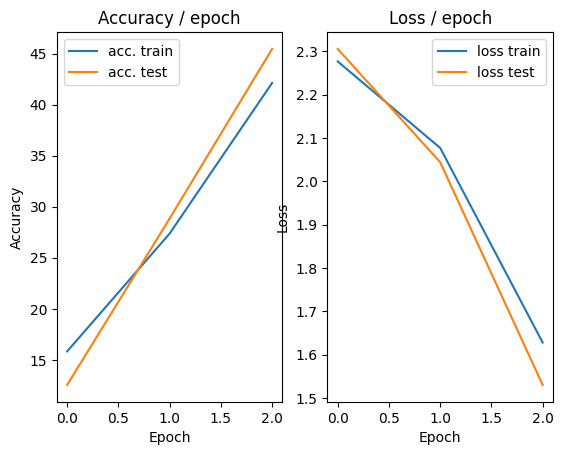

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.373s (0.373s)	Loss 1.5577 (1.5577)	Prec@1  39.8 ( 39.8)	Prec@5  92.2 ( 92.2)


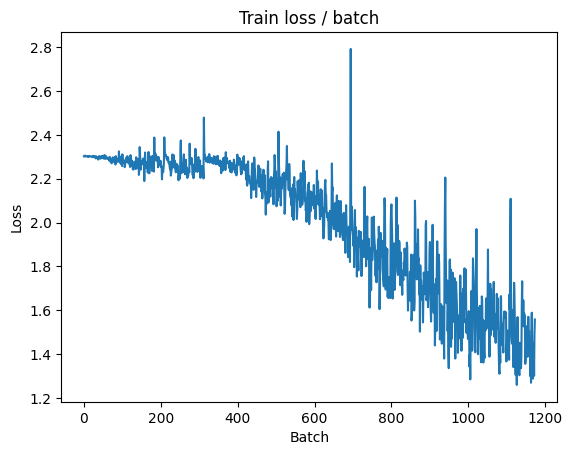

[TRAIN Batch 200/391]	Time 0.118s (0.129s)	Loss 1.1805 (1.3821)	Prec@1  63.3 ( 51.2)	Prec@5  96.9 ( 93.0)


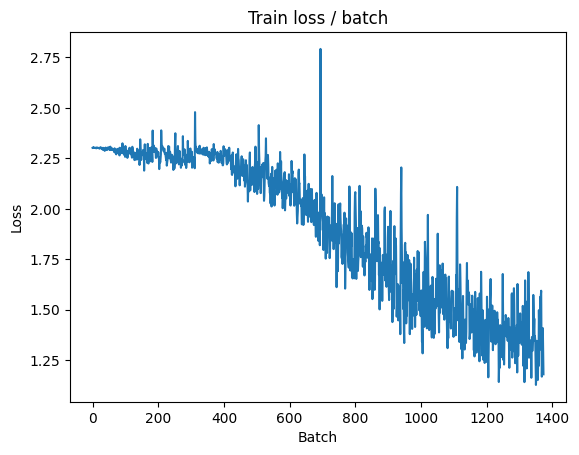


===============> Total time 49s	Avg loss 1.3476	Avg Prec@1 52.26 %	Avg Prec@5 93.37 %

[EVAL Batch 000/079]	Time 0.200s (0.200s)	Loss 1.1087 (1.1087)	Prec@1  62.5 ( 62.5)	Prec@5  96.1 ( 96.1)

===============> Total time 4s	Avg loss 1.2509	Avg Prec@1 55.14 %	Avg Prec@5 94.88 %



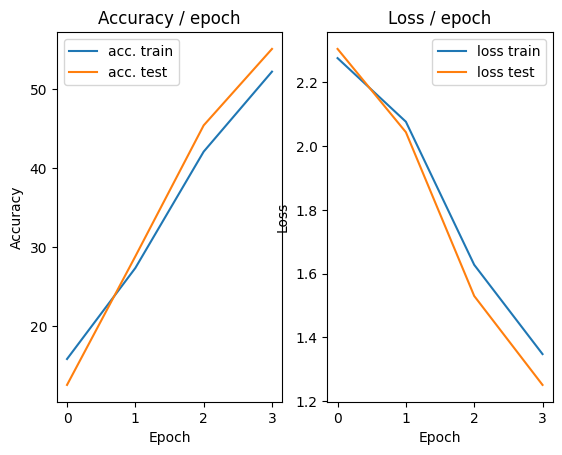

=== EPOCH 5 =====



KeyboardInterrupt: 

In [8]:
main(128, 0.1, cuda=False)